<a href="https://colab.research.google.com/github/Andresmup/PyTorch_Arquitecture_Comparison/blob/main/PyTorch_Arquitecture_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ABSTRACT**

Este proyecto busca proporcionar un marco práctico comparativo entre diferentes arquitecturas CNN, realizando diferentes pruebas en base a la inferencia de clases en imágenes de comida, es decir, aplicar un modelo de clasificación deep learning a un conjunto de imágenes de comida etiquetadas. Focalizándose en dos grandes arquitecturas como son ResNet y EfficientNet. Se utiliza Pytorch como framework, realizando una estructura de código recomendada y replicable. El objetivo es poder bajo unas mismas condiciones comparar diferentes aspectos de cada una. Además, para esta tarea se decidió realizar pruebas con diferentes modelos de cada una de estas arquitecturas. A fin de poder ampliar el abanico de opciones, lo que permite poder seleccionar la arquitectura y modelo más conveniente según las necesidades del usuario.
también se busca mostrar un uso amigable con el desarrollador, lo que permite realizar bastantes pruebas sin tener código repetido. Pudiendo hacer foco en los modelos al tener como base funciones creadas que facilitan el entrenamiento, testeo y obtención de datos relevantes.

# **IMPORTACIÓN LIBRERIAS Y DATOS**

Para este proyecto y de cara a que sea usado como base de otros es importante contar con las librerías mencionadas a continuación. Siendo pytorch el framework a usar se utilizarán diferentes dependencias a lo largo del código. Puesto que se trabaja con imágenes se necesita importar torchvision.

In [1]:
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


También se necesitan librerías comunes de python como os y ramdom. Puesto que se van a realizar gráficos se utilizará matplotlib. Como también el uso de la función summary de torchinfo, la cual se implementa adelante permite comprender como se distribuye las diferentes capas de los modelos.

In [2]:
# Continue imports
import os

import matplotlib.pyplot as plt
import random

from torch import nn
from torchvision import transforms
from torchvision.transforms import v2


# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


[INFO] Couldn't find torchinfo... installing it.


Una parte muy importante y a resaltar de este proyecto es el uso de funciones creadas en post de facilitar la implementación de un modelo al desarrollador. Estas librerías fueron creadas como complemento al proyecto, para poder así focalizarse en los modelos y no tener estructuras de código repetidas.

Link al repositorio: https://github.com/Andresmup/pytorch_functions

In [3]:
# Try to import the pytorch_functions directory, download it from GitHub if it doesn't work
try:
    from pytorch_functions import data_setup, engine, utils, plot_loss_curves, make_predictions, train_model, pred_and_plot_image
except ImportError:
    # Get the pytorch_functions scripts
    print("[INFO] Couldn't find pytorch_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/Andresmup/pytorch_functions
    from pytorch_functions import data_setup, engine, utils, plot_loss_curves, make_predictions, train_model, pred_and_plot_image

[INFO] Couldn't find pytorch_functions scripts... downloading them from GitHub.
Cloning into 'pytorch_functions'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 64 (delta 31), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (64/64), 20.53 KiB | 1.47 MiB/s, done.
Resolving deltas: 100% (31/31), done.


Para poder realizar las comparaciones entre modelos y arquitecturas se decidió usar un set de imágenes etiquetadas sin ruido, es decir, un set de datos controlado con 3 clases el cual se encuentra en un repositorio como archivo .zip.

In [4]:
import zipfile

from pathlib import Path

import requests

#Copy custom images from "https://github.com/Andresmup/ArchivosDataScience/raw/main/custom_images.zip"

#Setup path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download food images
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/Andresmup/ArchivosDataScience/raw/main/pizza_steak_sushi.zip")
        print("Downloading food images...")
        f.write(request.content)

    # Unzip food images
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping food images...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping food images...


Una vez descargadas las imágenes se define un path para el set de entrenamiento y testeo.

In [5]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# **USO GPU**

Una parte muy importante a la hora de realizar proyectos con pytorch en especial cuando se trabaja con arquitecturas base, es el aprovechamiento de una gpu; el uso de cuda nos permite utilizar el paralelismo que ofrecen las gpu en post de mejorar los tiempos de ejecución.
Esto es crucial ya que en caso de tener que realizar los entrenamientos en una cpu su tiempo de ejecución mínimo ronda los 250 / 300 segundos, lo cual es una diferencia muy notable. Siendo que esto se agravaría para casos donde los sets de datos fueran más grandes y complejos, como también usando modelos con más parámetros.

In [6]:
#Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# **TRANFORMS**

Cuando se trabaja con modelos base es muy importante que los datos que utilicemos para el testeo, pero sobre todo en el entrenamiento coincidan con las imágenes que se utilizaron para realizar el preentrenamiento de dichos modelos.
Por lo que se debe escalar las imágenes al mismo tamaño que se utilizaron para el entrenamiento de cada modelo, como también normalizar los canales de colores de acuerdo con la media y desvío estándar de cada uno de los canales originales.
En nuestro caso estos valores son iguales entre nuestros modelos, pero se debe tener este dato en cuenta en caso de agregar otro modelo y/o otra arquitectura puesto que varían.


In [7]:
# Create a transform
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

Como practica recomendada se crean los dataloader correspondientes al train y test; además se extraen las clases. Para ello se usa una de las funciones importadas anteriormente la cual fue creada con este propósito.

In [8]:
#Define batch size
BATCH_SIZE = 32

# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names =  data_setup.create_dataloaders(train_dir=train_dir,#Train path
                                                                               test_dir=test_dir, #Test oath
                                                                               train_transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               test_transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=BATCH_SIZE) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c84f16ed750>,
 ['pizza', 'steak', 'sushi'])

# **EFFICIENTNET_B0**

A continuación, se realiza la importación y preparación del primer modelo que vamos a poner a prueba. Este es parte de la arquitectura EfficientNet, por lo que los otros 2 el procedimiento será similar; a fines de elaborar una guía completa se procede a explicar este primer caso en detalle.

El primer paso es descargar el modelo efficientnet_b0, además utilizaremos modelos preentrenados en necesario descargar los weights. Puesto que querremos cargar el modelo; tener capas ya entrenadas y otras o a fin de que estas se adapten a nuestro set de datos.

In [9]:
#Download and setting model with weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_b0(weights="DEFAULT")

weights_efficientnet_b0 = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model_efficientnet_b0 = torchvision.models.efficientnet_b0(weights=weights_efficientnet_b0).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 152MB/s]


El siguiente paso lo que hace es congelar las capas de selección de parámetros, es decir, en un modelo con bloques de features selection y bloques de clasificación lo que hacemos en este caso es dejar como entrenables los bloques de clasificación únicamente.

In [10]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_efficientnet_b0.features.parameters():
    param.requires_grad = False

Puesto que los modelos tienen una capa de clasificación la cual varia respecto a nuestras necesidades tenemos que crear una. Nuestra capa de clasificación contara con un módulo dropout el cual tendrá una probabilidad de 0.2, este módulo en caso de activarse apagara dicha unidad. Esto es muy útil de cara a evitar el overfitting en el entrenamiento.
Como modulo para la clasificación se utiliza un módulo lineal. Es muy importante que además de tener el número de clases de salida igual a la cantidad de clases que tenemos (3 en este caso) también su cantidad de parámetros de ingreso coincida con el ultimo módulo de features selection para evitar errores de multiplicación en matrices.

In [11]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_efficientnet_b0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

Utilizando la función summary importada anteriormente podemos ver características de nuestro modelo de una forma visual. Observando la cantidad de bloques, sus parámetros. También vemos como salvo la capa de clasificación el resto no son entrenables tal cual definimos antes.

In [12]:
# Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model_efficientnet_b0,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

Como puntos para tener en cuenta nuestro modelo cuenta con 4,011,391 de parámetros y tiene un peso estimado de 3487.41MB.

# **TRAIN EFFICIENTNET_B0**

or cuestiones de paridad entre modelos se aplica el mismo tipo de transformación a cada uno. Ya que buscamos poder realizar comparaciones con condiciones iniciales símiles. Aunque en un caso práctico la transformación de entrenamiento para nuestro modelo podría contar con un proceso de data augmentation a fin de maximizar su rendimiento.

In [13]:
#Copy previous transform
manual_transforms_efficientnet_b0 = manual_transforms

Gracias a la implementación las funciones en pytorch la etapa de entrenamiento se reduce a aplicar dicha función. La cual nos pide como argumentos el modelo, los directorios con nuestros datos de entrenamiento y testeo, la transformación a realizar, el tipo de optimizador, la cantidad de etapas, el tamaño del mini lote y el ritmo de aprendizaje. Además se le proporciona un string ya que guardara nuestro modelo en un archivo .pth, él se puede descargar y almacenar, lo que permite desplegarlo e implementarlo fácilmente para realizar predicciones.
La función nos devolverá los valores de precisión y perdida para la etapa de test y train en cada etapa como así también el tiempo de ejecución que tuvo. Lo cual usaremos más adelante para realizar las comparaciones entre modelos.

In [14]:
#Training
results_efficientnet_b0, time_efficientnet_b0 = train_model.train_model(
    model=model_efficientnet_b0, #model
    train_dir="data/pizza_steak_sushi/train", #train path
    test_dir="data/pizza_steak_sushi/test", #test path
    train_transform=manual_transforms_efficientnet_b0, #train transformation
    test_transform=manual_transforms_efficientnet_b0, #test trasformation
    model_save_name="model_efficientnet_b0.pth", #how to name the model saved
    optimizer=torch.optim.Adam(model_efficientnet_b0.parameters(),lr=0.001), #optimizer
    NUM_EPOCHS=5, #num of epochs
    BATCH_SIZE=32, #size of mini batchs
    LEARNING_RATE=0.001 #learning rate
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 17.564 seconds
[INFO] Saving model to: models/model_efficientnet_b0.pth


Como podemos observar con cada etapa de entrenamiento la función perdida se redujo y la precisión aumento tanto para los datos de entrenamiento como para los de testeo.

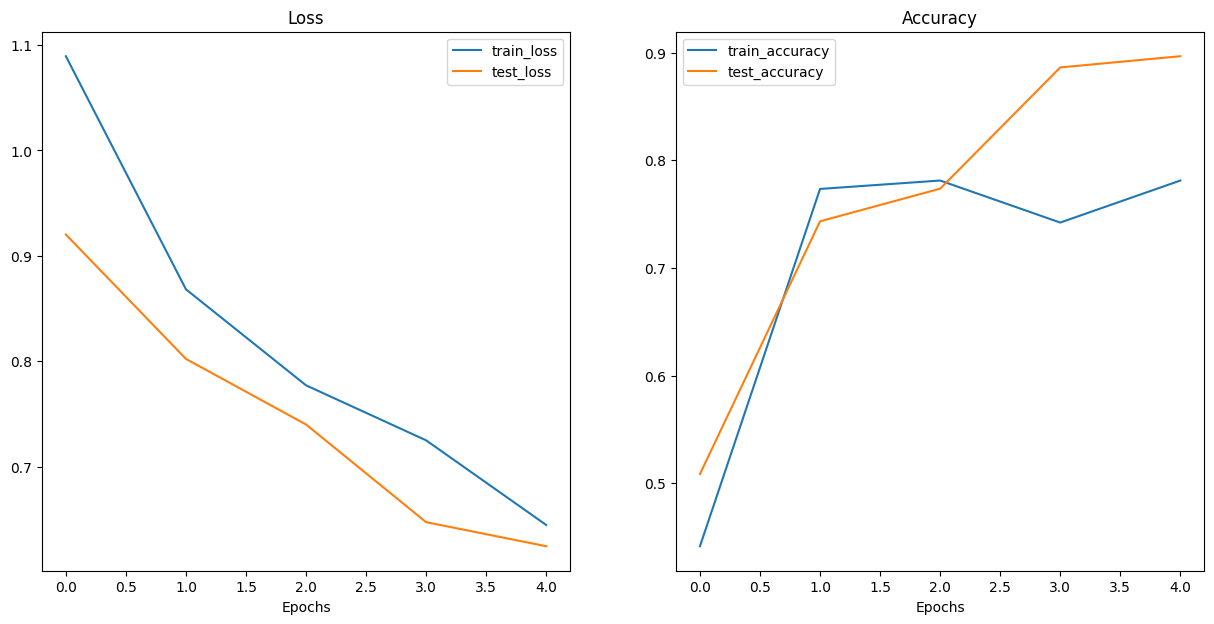

In [15]:
# Plot the loss curves of our model
plot_loss_curves.plot_loss_curves(results_efficientnet_b0)

# **EFFICIENTNET_B1**

Procedemos a realizar los mismos pasos para nuestro modelo efficientnet_b1.

In [16]:
#Download and setting model with weights
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT)
efficientnet_b1(weights="DEFAULT")

weights_efficientnet_b1 = torchvision.models.EfficientNet_B1_Weights.DEFAULT # .DEFAULT = best available weights
model_efficientnet_b1 = torchvision.models.efficientnet_b1(weights=weights_efficientnet_b1).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 60.8MB/s]


In [17]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_efficientnet_b1.features.parameters():
    param.requires_grad = False

In [18]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_efficientnet_b1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [19]:
# Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model_efficientnet_b1,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

Como puntos para tener en cuenta nuestro modelo cuenta con 6,517,027 de parámetros y tiene un peso estimado de 4831.34MB

# **TRAIN EFFICIENTNET_B1**

Se replica el procedimiento de entrenamiento establecido como base para obtener condiciones iniciales semejantes.

In [20]:
#Copy previous transform
manual_transforms_efficientnet_b1 = manual_transforms

In [21]:
#Training
results_efficientnet_b1, time_efficientnet_b1 = train_model.train_model(
    model=model_efficientnet_b1,
    train_dir="data/pizza_steak_sushi/train",
    test_dir="data/pizza_steak_sushi/test",
    train_transform=manual_transforms_efficientnet_b1,
    test_transform=manual_transforms_efficientnet_b1,
    model_save_name="model_efficientnet_b1.pth",
    optimizer=torch.optim.Adam(model_efficientnet_b1.parameters(),lr=0.001),
    NUM_EPOCHS=5,
    BATCH_SIZE=32,
    LEARNING_RATE=0.001
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0675 | train_acc: 0.5391 | test_loss: 0.9913 | test_acc: 0.7235
Epoch: 2 | train_loss: 0.9406 | train_acc: 0.7109 | test_loss: 0.9386 | test_acc: 0.7443
Epoch: 3 | train_loss: 0.8566 | train_acc: 0.8594 | test_loss: 0.8468 | test_acc: 0.8475
Epoch: 4 | train_loss: 0.8440 | train_acc: 0.7578 | test_loss: 0.7715 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.7215 | train_acc: 0.7656 | test_loss: 0.7288 | test_acc: 0.8674
[INFO] Total training time: 15.781 seconds
[INFO] Saving model to: models/model_efficientnet_b1.pth


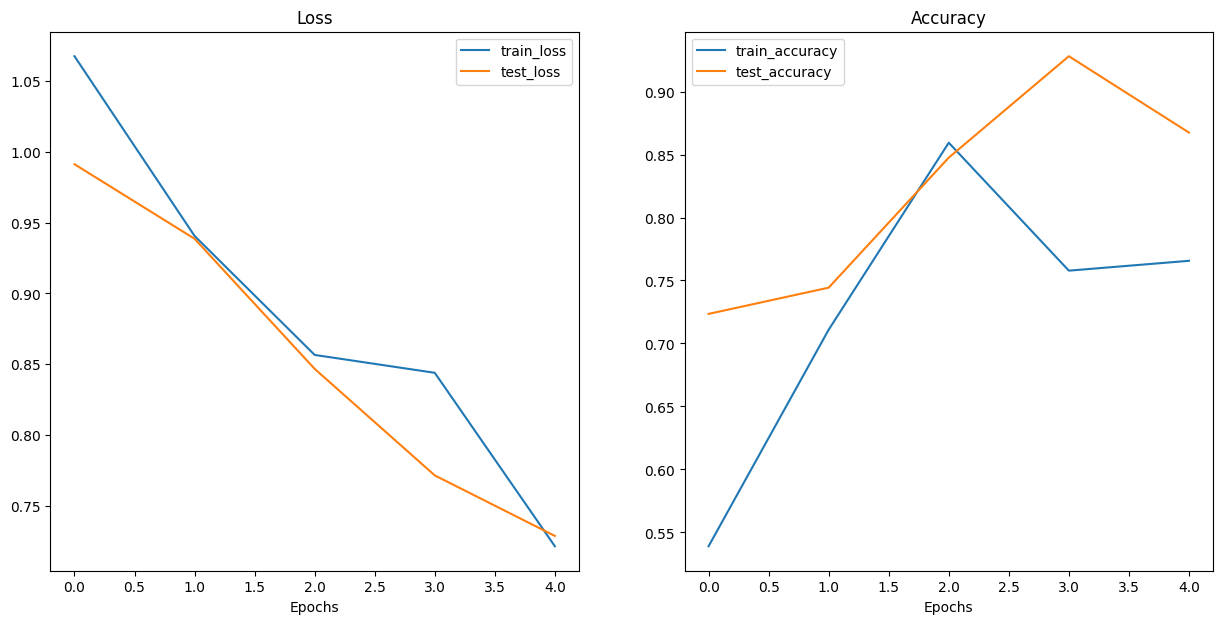

In [22]:
# Plot the loss curves of our model
plot_loss_curves.plot_loss_curves(results_efficientnet_b1)

# **EFFICIENTNET_B2**

Procedemos a realizar los mismos pasos para nuestro modelo efficientnet_b2.

In [23]:
#Download and setting model with weights
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)
efficientnet_b2(weights="DEFAULT")

weights_efficientnet_b2 = torchvision.models.EfficientNet_B2_Weights.DEFAULT # .DEFAULT = best available weights
model_efficientnet_b2 = torchvision.models.efficientnet_b2(weights=weights_efficientnet_b2).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 168MB/s]


In [24]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_efficientnet_b2.features.parameters():
    param.requires_grad = False

In [25]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_efficientnet_b2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1408,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [26]:
# Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model_efficientnet_b2,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

Como puntos para tener en cuenta nuestro modelo cuenta con 7,705,221 de parámetros y tiene un peso estimado de 5067.62MB

# **TRAIN EFFICIENTNET_B2**

Se replica el procedimiento de entrenamiento establecido como base para obtener condiciones iniciales semejantes.

In [27]:
#Copy previous transform
manual_transforms_efficientnet_b2 = manual_transforms

In [28]:
#Training
results_efficientnet_b2, time_efficientnet_b2 = train_model.train_model(
    model=model_efficientnet_b2,
    train_dir="data/pizza_steak_sushi/train",
    test_dir="data/pizza_steak_sushi/test",
    train_transform=manual_transforms_efficientnet_b2,
    test_transform=manual_transforms_efficientnet_b2,
    model_save_name="model_efficientnet_b2.pth",
    optimizer=torch.optim.Adam(model_efficientnet_b2.parameters(),lr=0.001),
    NUM_EPOCHS=5,
    BATCH_SIZE=32,
    LEARNING_RATE=0.001
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1106 | train_acc: 0.3281 | test_loss: 0.9516 | test_acc: 0.6714
Epoch: 2 | train_loss: 0.8806 | train_acc: 0.8008 | test_loss: 0.8803 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7929 | train_acc: 0.7891 | test_loss: 0.7989 | test_acc: 0.8049
Epoch: 4 | train_loss: 0.7458 | train_acc: 0.7305 | test_loss: 0.6949 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.6431 | train_acc: 0.7891 | test_loss: 0.6901 | test_acc: 0.8561
[INFO] Total training time: 11.333 seconds
[INFO] Saving model to: models/model_efficientnet_b2.pth


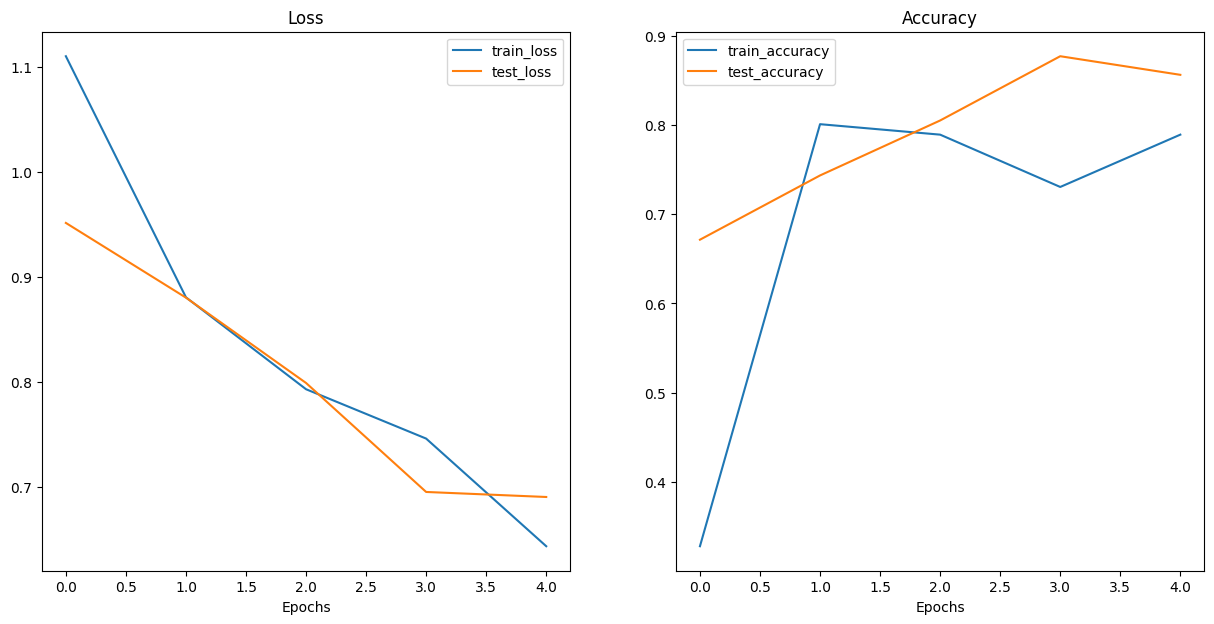

In [29]:
# Plot the loss curves of our model
plot_loss_curves.plot_loss_curves(results_efficientnet_b2)

# **RESNET 34**

Ahora se utilizará la arquitectura resnet, el principio de los pasos a seguir, aunque el código para varie ligeramente ya que cada arquitectura puede tener sus funciones y procesos particulares, además de nomenclatura de bloques diferente.

In [30]:
#Download and setting model with weights
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

resnet34(weights=ResNet34_Weights.DEFAULT)
resnet34(weights="DEFAULT")

weights_resnet_34 = torchvision.models.ResNet34_Weights.DEFAULT # .DEFAULT = best available weights
model_resnet_34 = torchvision.models.resnet34(weights=weights_resnet_34).to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 167MB/s]


Para poder dejar como no entrenables los bloques de feature selection debemos aplicar la regla de set requires_grad false para todos. Salvo para cualquier bloque que empiece con Linear (el bloque de clasificación).

In [31]:
#Setting trainable to false
for name, param in model_resnet_34.named_parameters():
    if not name.startswith('Linear'):  # Exclude parameters of the classifier layer
        param.requires_grad = False

In [32]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_resnet_34.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=512,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)


In [33]:
summary(model_resnet_34,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

Como puntos para tener en cuenta nuestro modelo cuenta con 21,286,211 de parámetros y tiene un peso estimado de 2018.33MB.

# **TRAIN RESNET 34**

Se replica el procedimiento de entrenamiento establecido como base para obtener condiciones iniciales semejantes.

In [34]:
#Copy previous transform
manual_transforms_resnet_34 = manual_transforms

In [35]:
#Training
results_resnet_34, time_resnet_34 = train_model.train_model(
    model=model_resnet_34,
    train_dir="data/pizza_steak_sushi/train",
    test_dir="data/pizza_steak_sushi/test",
    train_transform=manual_transforms_resnet_34,
    test_transform=manual_transforms_resnet_34,
    model_save_name="model_resnet_34.pth",
    optimizer=torch.optim.Adam(model_resnet_34.parameters(),lr=0.001),
    NUM_EPOCHS=5,
    BATCH_SIZE=32,
    LEARNING_RATE=0.001
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1910 | train_acc: 0.3086 | test_loss: 1.2879 | test_acc: 0.2917
Epoch: 2 | train_loss: 1.0075 | train_acc: 0.5195 | test_loss: 0.8548 | test_acc: 0.6383
Epoch: 3 | train_loss: 0.8791 | train_acc: 0.5234 | test_loss: 0.8472 | test_acc: 0.7017
Epoch: 4 | train_loss: 0.8519 | train_acc: 0.5820 | test_loss: 0.7355 | test_acc: 0.7434
Epoch: 5 | train_loss: 0.8329 | train_acc: 0.6406 | test_loss: 0.6751 | test_acc: 0.7633
[INFO] Total training time: 10.245 seconds
[INFO] Saving model to: models/model_resnet_34.pth


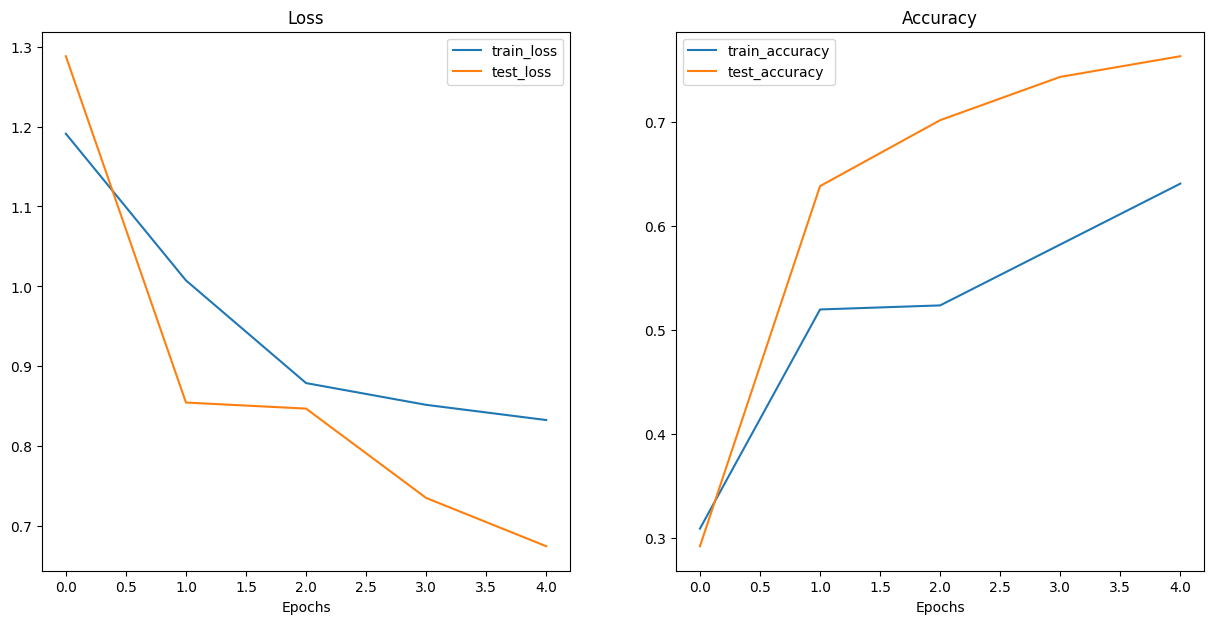

In [36]:
# Plot the loss curves of our model
plot_loss_curves.plot_loss_curves(results_resnet_34)

# **RESNET 50**

Procedemos a realizar los mismos pasos para nuestro modelo resnet_50.

In [37]:
#Download and setting model with weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

resnet50(weights=ResNet50_Weights.DEFAULT)
resnet50(weights="DEFAULT")

weights_resnet_50 = torchvision.models.ResNet50_Weights.DEFAULT # .DEFAULT = best available weights
model_resnet_50 = torchvision.models.resnet50(weights=weights_resnet_50).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


In [38]:
#Setting trainable to false
for name, param in model_resnet_50.named_parameters():
    if not name.startswith('Linear'):  # Exclude parameters of the classifier layer
        param.requires_grad = False


In [39]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)


# Recreate the classifier layer and seed it to the target device
model_resnet_50.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=2048,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)


In [40]:
# Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model_resnet_50,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

Como puntos para tener en cuenta nuestro modelo cuenta con 23,514,179 de parámetros y tiene un peso estimado de 5803.68MB.

# **TRAIN RESNET 50**

Se replica el procedimiento de entrenamiento establecido como base para obtener condiciones iniciales semejantes.

In [41]:
#Copy previous transform
manual_transforms_resnet_50 = manual_transforms

In [42]:
#Training
results_resnet_50, time_resnet_50 = train_model.train_model(
    model=model_resnet_50,
    train_dir="data/pizza_steak_sushi/train",
    test_dir="data/pizza_steak_sushi/test",
    train_transform=manual_transforms_resnet_50,
    test_transform=manual_transforms_resnet_50,
    model_save_name="model_resnet_50.pth",
    optimizer=torch.optim.Adam(model_resnet_50.parameters(),lr=0.001),
    NUM_EPOCHS=5,
    BATCH_SIZE=32,
    LEARNING_RATE=0.001
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0664 | train_acc: 0.4844 | test_loss: 0.9776 | test_acc: 0.7121
Epoch: 2 | train_loss: 0.8942 | train_acc: 0.7656 | test_loss: 0.9081 | test_acc: 0.8343
Epoch: 3 | train_loss: 0.7823 | train_acc: 0.8320 | test_loss: 0.8336 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.7097 | train_acc: 0.7891 | test_loss: 0.7907 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6332 | train_acc: 0.7930 | test_loss: 0.7625 | test_acc: 0.8049
[INFO] Total training time: 11.795 seconds
[INFO] Saving model to: models/model_resnet_50.pth


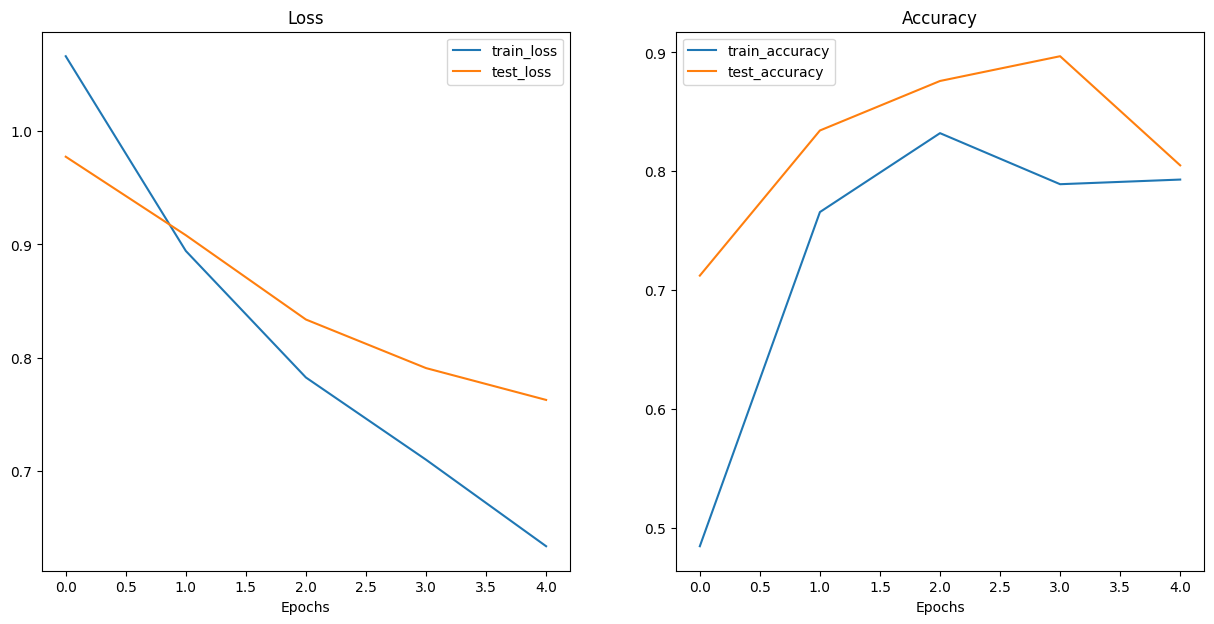

In [43]:
# Plot the loss curves of our model
plot_loss_curves.plot_loss_curves(results_resnet_50)

# **RESNET 101**

Procedemos a realizar los mismos pasos para nuestro modelo resnet_101.

In [44]:
#Download and setting model with weights
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

resnet101(weights=ResNet101_Weights.DEFAULT)
resnet101(weights="DEFAULT")

weights_resnet_101 = torchvision.models.ResNet101_Weights.DEFAULT # .DEFAULT = best available weights
model_resnet_101 = torchvision.models.resnet101(weights=weights_resnet_101).to(device)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 208MB/s]


In [45]:
#Setting trainable to false
for name, param in model_resnet_101.named_parameters():
    if not name.startswith('Linear'):  # Exclude parameters of the classifier layer
        param.requires_grad = False

In [46]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)


# Recreate the classifier layer and seed it to the target device
model_resnet_101.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=2048,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)


In [47]:
# Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model_resnet_101,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

Como puntos para tener en cuenta nuestro modelo cuenta con 42,506,307 de parámetros y tiene un peso estimado de 8500.04MB.

# **TRAIN RESNET 101**

Se replica el procedimiento de entrenamiento establecido como base para obtener condiciones iniciales semejantes.

In [48]:
#Copy previous transform
manual_transforms_resnet_101 = manual_transforms

In [49]:
#Training
results_resnet_101, time_resnet_101 = train_model.train_model(
    model=model_resnet_101,
    train_dir="data/pizza_steak_sushi/train",
    test_dir="data/pizza_steak_sushi/test",
    train_transform=manual_transforms_resnet_101,
    test_transform=manual_transforms_resnet_101,
    model_save_name="model_resnet_101.pth",
    optimizer=torch.optim.Adam(model_resnet_101.parameters(),lr=0.001),
    NUM_EPOCHS=5,
    BATCH_SIZE=32,
    LEARNING_RATE=0.001
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0403 | train_acc: 0.5195 | test_loss: 1.0675 | test_acc: 0.4460
Epoch: 2 | train_loss: 0.8301 | train_acc: 0.7734 | test_loss: 0.8873 | test_acc: 0.7330
Epoch: 3 | train_loss: 0.6726 | train_acc: 0.8906 | test_loss: 0.7865 | test_acc: 0.8049
Epoch: 4 | train_loss: 0.5946 | train_acc: 0.9414 | test_loss: 0.7090 | test_acc: 0.8248
Epoch: 5 | train_loss: 0.5265 | train_acc: 0.8086 | test_loss: 0.6778 | test_acc: 0.8352
[INFO] Total training time: 13.553 seconds
[INFO] Saving model to: models/model_resnet_101.pth


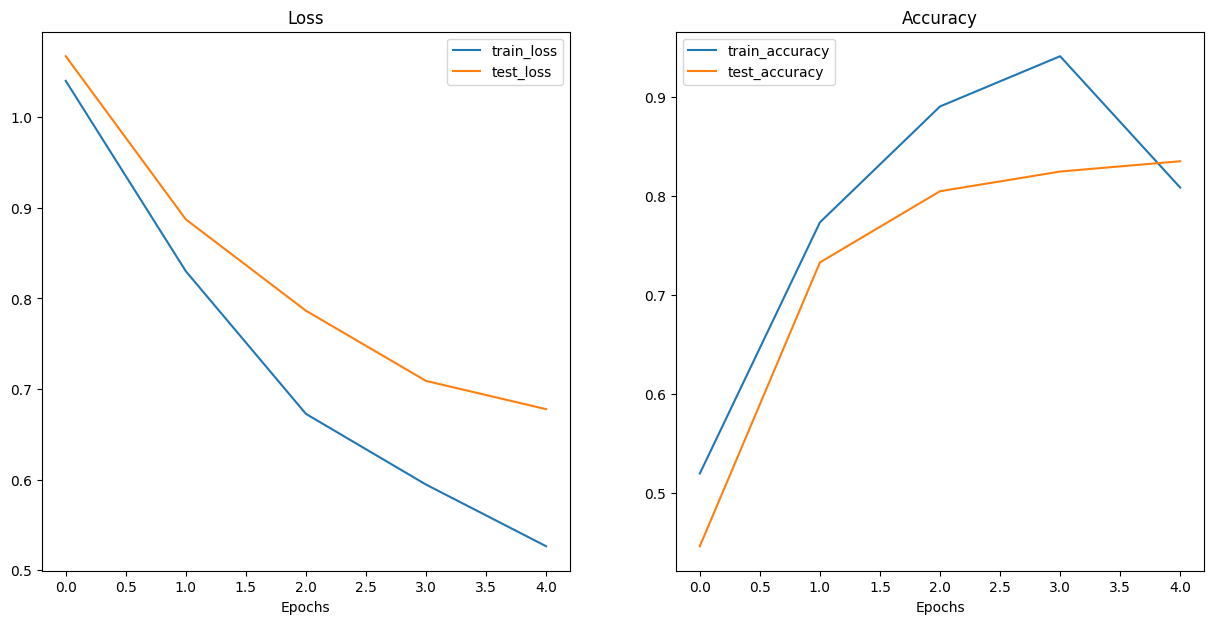

In [50]:
# Plot the loss curves of our model
plot_loss_curves.plot_loss_curves(results_resnet_101)

# **COMPARACIÓN Y EVALUACIÓN MODELOS**

En esta sección se proceden a realizar diferentes comparaciones entre los modelos, utilizando los valores que estos retornaron en sus respectivas etapas de entrenamiento y testeo. Se utilizarán gráficos a fin de hacerlos más entendibles.

Definimos una función que nos ayudara a extraer los mejores resultados en las diferentes etapas.

In [51]:
def get_max_test_acc_results(results):
    # Getting index value for best test_acc
    max_test_acc_index = results['test_acc'].index(max(results['test_acc']))

    # Getting values
    max_test_acc_values = {
        'train_loss': results['train_loss'][max_test_acc_index],
        'train_acc': results['train_acc'][max_test_acc_index],
        'test_loss': results['test_loss'][max_test_acc_index],
        'test_acc': results['test_acc'][max_test_acc_index]
    }

    return max_test_acc_values

In [52]:
#Getting best values for each model.

max_test_acc_efficientnet_b0 = get_max_test_acc_results(results_efficientnet_b0)
max_test_acc_efficientnet_b1 = get_max_test_acc_results(results_efficientnet_b1)
max_test_acc_efficientnet_b2 = get_max_test_acc_results(results_efficientnet_b2)
max_test_acc_resnet_34 = get_max_test_acc_results(results_resnet_34)
max_test_acc_resnet_50 = get_max_test_acc_results(results_resnet_50)
max_test_acc_resnet_101 = get_max_test_acc_results(results_resnet_101)

Procedemos a usar los resultados obtenidos a fin de comparar las etapas con los datos test para poder evaluar los mejores valores de precisión y función perdida.

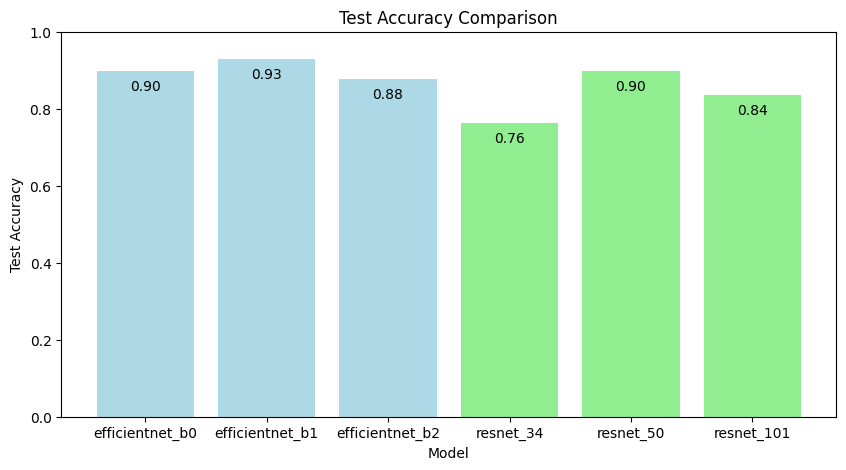

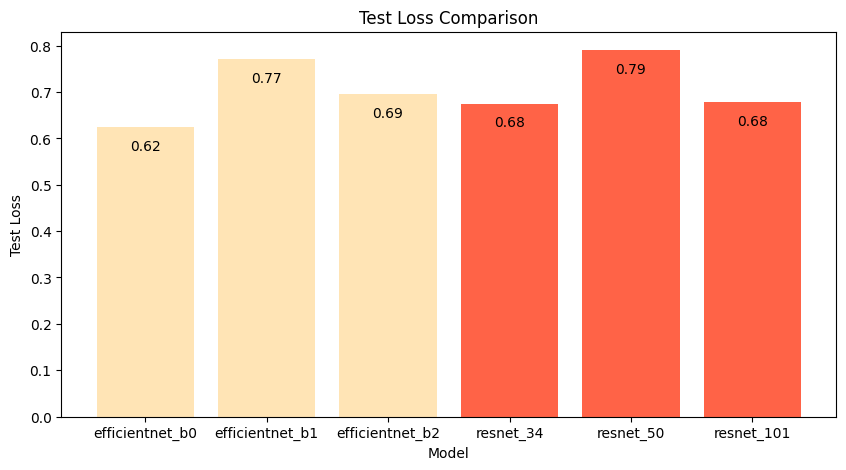

In [53]:
#Lists
models = ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'resnet_34', 'resnet_50', 'resnet_101']
test_acc_values = []
test_loss_values = []

#Uses for loop
for model in models:
    data = globals()[f'max_test_acc_{model}']
    test_acc_values.append(data['test_acc'])
    test_loss_values.append(data['test_loss'])

# Plot test_acc
plt.figure(figsize=(10, 5))
colors = ['lightblue' if 'efficientnet' in model else 'lightgreen' for model in models]
bars = plt.bar(models, test_acc_values, color=colors)

# Colors separate for resnet and efficientnet
for bar, value in zip(bars, test_acc_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{value:.2f}', ha='center', color='black')

plt.title('Test Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.ylim([0, 1])
plt.show()

# Plot test_loss
plt.figure(figsize=(10, 5))
colors = ['moccasin' if 'efficientnet' in model else 'tomato' for model in models]
bars = plt.bar(models, test_loss_values, color=colors)

# Colors separate for resnet and efficientnet
for bar, value in zip(bars, test_loss_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{value:.2f}', ha='center', color='black')

plt.title('Test Loss Comparison')
plt.xlabel('Model')
plt.ylabel('Test Loss')
plt.show()

Como se puede observar en el gráfico anterior hay un mejor desempeño en precisión y función de perdida de la arquitectura efficientnet respecto a resnet en líneas generales.

Siendo el modelo efficientnet_b1 el que mejor (mayor) efectividad tuvo a la hora de clasificar imágenes que no había visto antes (test). Seguido por efficientnet_b0 y resnet_101. Aunque las diferencias son mínimas.

Por otra parte, el modelo efficientnet_b0 fue el que mejor (menor) valor de función de perdida tuvo. Seguido de resnet_101 y resnet_34 lo cual es sorprendente teniendo en cuenta que es el modelo que menor cantidad de parámetros tiene.

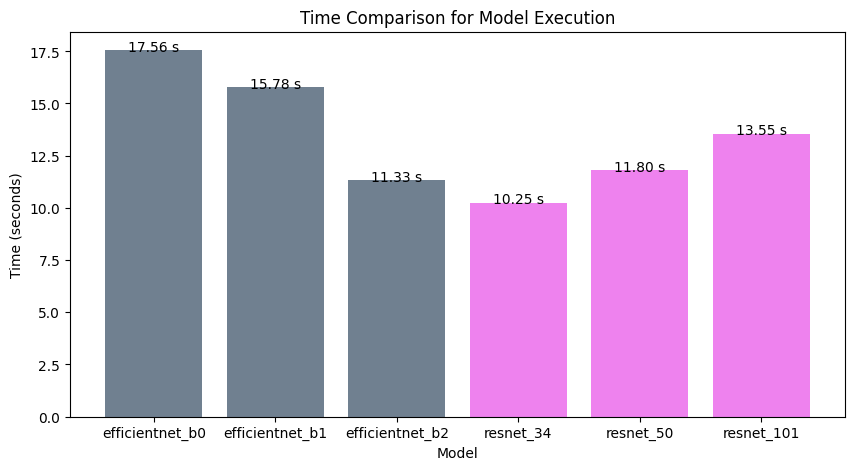

In [54]:
# Lists
models = ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'resnet_34', 'resnet_50', 'resnet_101']
time_values = [time_efficientnet_b0, time_efficientnet_b1, time_efficientnet_b2, time_resnet_34, time_resnet_50, time_resnet_101]

# Plot execution time
plt.figure(figsize=(10, 5))
colors = ['slategray' if 'efficientnet' in model else 'violet' for model in models]
bars = plt.bar(models, time_values, color=colors)

# Colors separate for resnet and efficientnet
for bar, value in zip(bars, time_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{value:.2f} s', ha='center', color='black')
plt.title('Time Comparison for Model Execution')
plt.xlabel('Model')
plt.ylabel('Time (seconds)')
plt.show()

Sin embargo, en el aspecto de tiempo de ejecución la arquitectura que sobresale es resnet.
Siendo resnet_34 el modelo más ágil, aunque efficientnet_b2 no hace un más papel en este ámbito seguido de resnet_50 y resnet_101.
Se debe aclarar que estos resultados se verán incrementados cuanto más grandes sean las muestras de entrenamientos y testeo; como también cuantas más clases tengamos. Por lo que estas diferencias serian mayores aún.

# **SELECCIÓN DE MODELO**

En esta sección abordaremos que selección de modelo haríamos en situaciones particulares.

*   RESNET 34: Si nuestro caso de aplicación necesitara priorizar un modelo que requiera poco espacio en memoria y un tiempo de entrenamiento rápido, resnet 34 sería la mejor opción. Ya que pesa solo 2000MB, lo cual sería muy conveniente en casos donde tengamos limitaciones de hardware y obtuvo el mejor tiempo de ejecución en la etapa de entrenamiento. Obviamente para poder obtener estos resultados estamos ante el modelo que peor desempeño tuvo de precisión.
*   EFFICIENTNET B0: Este sería el caso contrario, si buscáramos un modelo con muy buena precisión y valores de la función perdida bajos sin importar el tiempo de ejecución efficientnet b0 sería la mejor opción. Ya que tuvo muy buenos resultados a la hora de clasificar imágenes, pero sus tiempos de ejecución son los más elevados
*   EFFICIENTNET B2 y RESNET 50: Estos dos modelos serían los más equilibrados, ya que sus desempeños fueron muy buenos y sus tiempos de ejecución también. Serían los más balanceados, además tienen un peso similar 5800MB (resnet 50) y 5000MB (efficientnet b2).


# **PLOT**

Como practica extra haremos uso del modelo efficientnet b0 para realizar unas predicciones, en esta primera parte se seleccionaran 3 imágenes al azar y se evaluaran usando el modelo.
Mostrando cual es la clase predicha y el valor probabilístico de dicha predicción.

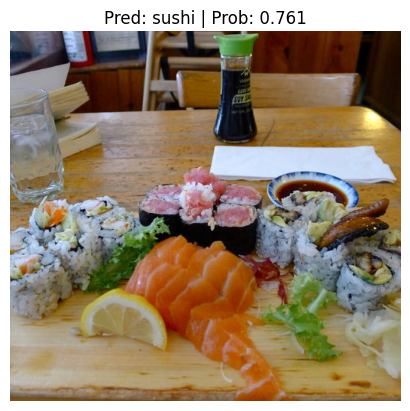

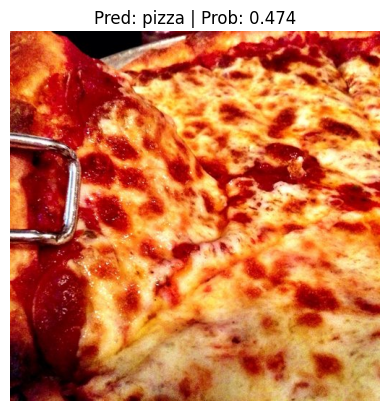

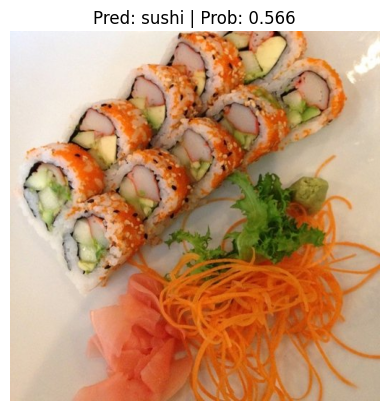

In [55]:
# Get a random list of image paths from test set

random_seed = 42
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image.pred_and_plot_image(model=model_efficientnet_b0,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

A continuación, seleccionaremos 9 imágenes al azar, se evaluarán con el modelo y se hará una comparación entre la clase arrojada por este y la clase real.

In [56]:
# Set seed
random.seed(5)

# Create empty list for samples and labels
random_samples = []
random_labels = []

# Assuming `data_loader` is your DataLoader
for batch in test_dataloader:
    # Unpack the batch
    samples, labels = batch

    # Iterate through the batch and get random samples
    for sample, label in zip(samples, labels):
        if random.random() < 0.1 and len(random_samples) < 9:  # Limit to 9 elements
            random_samples.append(sample)
            random_labels.append(label)

        if len(random_samples) >= 9:  # Break the loop once we have 9 elements
            break

    if len(random_samples) >= 9:  # Break the outer loop once we have 9 elements
        break

In [57]:
#Make predictions
custom_pred_probs= make_predictions.make_predictions(model=model_efficientnet_b0,
                             data=random_samples)

#Transform prediction probabilities -> predictions labels using argmax
random_custom_pred_classes = custom_pred_probs.argmax(dim=1)

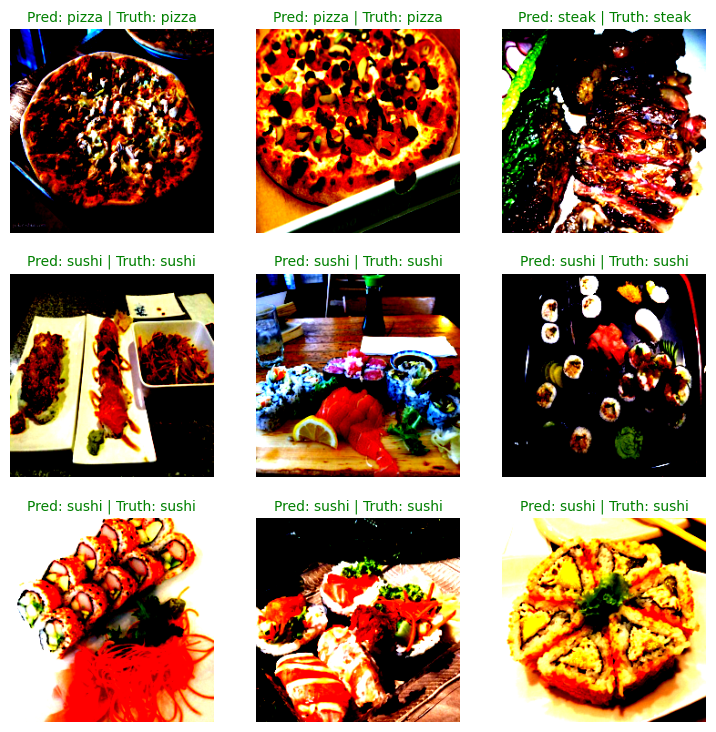

In [58]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(random_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze().permute(1,2,0).numpy())

  # Find the prediction label
  pred_label = class_names[random_custom_pred_classes[i]]

  # Get the truth label
  truth_label = class_names[random_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

# **CONCLUSIÓN**

En el presente trabajo se buscó crear un marco en el cual, a partir de una metodología de trabajo sencilla, fuera fácil realizar evaluaciones y comparaciones de diferentes arquitecturas y modelos, en el ámbito de la clasificación de imágenes.

Siendo que dicho cometido se pudo realizar a cabo, quedando confeccionada en el proceso una guía que documente los pasos. Pudiendo hacer más fácil la interpretación y los pasos que se tomaron; sirviendo como base para otros proyectos.

Además, se realizó un análisis de los resultados obtenidos los cuales dieron la posibilidad de ofrecer un abanico de alternativas para cada situación permitiendo una mayor flexibilidad de elección de modelo al desarrollador en base a las prioridades del caso.

Todo esto en un marco de programación utilizando pytorch aplicando buenas prácticas que permitan la escalabilidad y reproducción de lo ejecutado.


**ANDRÉS MUÑOZ PAMPILLÓN**